In [3]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import transforms
from PIL import Image
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [4]:
# ----------------------
# Configuration & Setup
# ----------------------
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [6]:
# --------------------
# Dataset Class
# --------------------
class SpectrogramDataset(Dataset):
    def __init__(self, soi_dir, cwi_dir, transform=None):
        self.filepaths = []
        self.labels = []
        
        # Load SOI images (label 0)
        for fname in os.listdir(soi_dir):
            self.filepaths.append(os.path.join(soi_dir, fname))
            self.labels.append(0)
            
        # Load CWI images (label 1)
        for fname in os.listdir(cwi_dir):
            self.filepaths.append(os.path.join(cwi_dir, fname))
            self.labels.append(1)
            
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img = Image.open(self.filepaths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

In [7]:
# ----------------------
# Data Preparation
# ----------------------
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Initialize dataset
soi_dir = '/home/HardDisk/yared/spectrogram-dataset/soi'
cwi_dir = '/home/HardDisk/yared/spectrogram-dataset/cwi'
full_dataset = SpectrogramDataset(soi_dir, cwi_dir, data_transforms)

# Split dataset
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
# --------------------
# Quantum Components
# --------------------
n_qubits = 6
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Input encoding
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)
    
    # Variational layers
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [9]:
# ----------------------
# Hybrid Model
# ----------------------
class HybridQNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Classical components with frozen ResNet
        self.resnet = torchvision.models.resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        
        # Trainable post-processing
        self.post_resnet = nn.Sequential(
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, n_qubits)
        )
        
        # Quantum components
        weight_shape = {"weights": (3, n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes=weight_shape)
        
        # Final classifier
        self.classifier = nn.Linear(n_qubits, 2)

    def forward(self, x):
        # Allow gradient flow through feature extractor
        with torch.set_grad_enabled(True):  # Critical for attack gradients
            x = self.resnet(x).flatten(1)
        x = self.post_resnet(x)
        x = self.qlayer(x)
        return self.classifier(x)

# Initialize model
model = HybridQNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/home/ea301b/anaconda3/envs/Pennylane/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ea301b/anaconda3/envs/Pennylane/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# ----------------------
# Training Loop
# ----------------------
def train_model(model, epochs=25):
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        # Calculate metrics
        train_loss = running_loss / len(train_loader.dataset)
        val_loss = val_loss / len(test_loader.dataset)
        val_acc = correct / total
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Accuracy: {val_acc:.2%}")

    return train_losses, val_losses

# Start training
train_losses, val_losses = train_model(model)

Epoch 1/25 | Train Loss: 0.4528 | Val Loss: 0.3358 | Accuracy: 93.51%
Epoch 2/25 | Train Loss: 0.2801 | Val Loss: 0.2125 | Accuracy: 94.31%
Epoch 3/25 | Train Loss: 0.2121 | Val Loss: 0.2021 | Accuracy: 94.19%
Epoch 4/25 | Train Loss: 0.1888 | Val Loss: 0.2068 | Accuracy: 92.78%
Epoch 5/25 | Train Loss: 0.1871 | Val Loss: 0.1573 | Accuracy: 95.17%
Epoch 6/25 | Train Loss: 0.1690 | Val Loss: 0.1532 | Accuracy: 95.29%
Epoch 7/25 | Train Loss: 0.1504 | Val Loss: 0.1555 | Accuracy: 95.47%
Epoch 8/25 | Train Loss: 0.1509 | Val Loss: 0.1409 | Accuracy: 95.10%
Epoch 9/25 | Train Loss: 0.1524 | Val Loss: 0.1427 | Accuracy: 95.10%
Epoch 10/25 | Train Loss: 0.1438 | Val Loss: 0.1452 | Accuracy: 94.74%
Epoch 11/25 | Train Loss: 0.1398 | Val Loss: 0.1387 | Accuracy: 95.10%
Epoch 12/25 | Train Loss: 0.1197 | Val Loss: 0.1425 | Accuracy: 95.29%
Epoch 13/25 | Train Loss: 0.1308 | Val Loss: 0.1702 | Accuracy: 94.06%
Epoch 14/25 | Train Loss: 0.1218 | Val Loss: 0.1567 | Accuracy: 94.98%
Epoch 15/25 | T

In [11]:
# ----------------------
# Quantum PGD Attack
# ----------------------
def quantum_pgd_attack(model, inputs, labels, eps=0.01, alpha=0.01, iters=10):
    original_inputs = inputs.clone().detach().to(device)
    adv_inputs = original_inputs.clone().detach().to(device)
    adv_inputs.requires_grad_(True)
    
    for _ in range(iters):
        # Forward pass with gradient tracking
        model.zero_grad()
        outputs = model(adv_inputs)
        loss = criterion(outputs, labels)
        
        # Calculate gradients
        loss.backward(retain_graph=True)
        
        with torch.no_grad():
            # Apply perturbation
            perturbation = alpha * adv_inputs.grad.sign()
            adv_inputs = adv_inputs + perturbation
            
            # Project to epsilon ball
            delta = adv_inputs - original_inputs
            delta = torch.clamp(delta, -eps, eps)
            adv_inputs = original_inputs + delta
            
        # Reset gradients for next iteration
        adv_inputs = adv_inputs.detach().requires_grad_(True)
    
    return adv_inputs.detach()

In [12]:
# ----------------------
# Robust Evaluation 
# ----------------------
def evaluate_robustness(model, loader, eps=0.01):
    model.eval()
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Generate adversarial examples
        adv_inputs = quantum_pgd_attack(model, inputs, labels, eps=eps)
        
        # Evaluate
        with torch.no_grad():
            outputs = model(adv_inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return correct / total

In [13]:
import torch
import numpy as np
from sklearn.metrics import classification_report

# Define the evaluate_robustness function
def evaluate_robustness(model, test_loader, epsilon=0.02, device='cpu'):

    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Generate adversarial examples using PGD
        adv_inputs = inputs.clone().detach().requires_grad_(True)
        for _ in range(10):  # PGD iterations
            outputs = model(adv_inputs)
            loss = torch.nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            adv_inputs = adv_inputs + epsilon * adv_inputs.grad.sign()
            adv_inputs = torch.clamp(adv_inputs, 0, 1)  # Ensure valid input range
            adv_inputs = adv_inputs.detach().requires_grad_(True)

        # Evaluate model on adversarial examples
        outputs = model(adv_inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    adv_accuracy = correct / total
    return adv_accuracy

# Final Evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Ensure device is defined
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate clean accuracy
clean_acc = sum(np.array(all_labels) == np.array(all_preds)) / len(all_labels)

# Calculate adversarial accuracy
adv_acc = evaluate_robustness(model, test_loader, epsilon=0.02, device=device)

print(f"\nFinal Results:")
print(f"Clean Accuracy: {clean_acc:.2%}")
print(f"Adversarial Accuracy (ε=0.02): {adv_acc:.2%}")

# Generate report
with open('performance_report_01.txt', 'w') as f:
    f.write("Hybrid Quantum-Classical Model Performance Report\n\n")
    f.write(f"Final Validation Accuracy: {clean_acc:.2%}\n")
    f.write(f"Adversarial Robustness (PGD): {adv_acc:.2%}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(all_labels, all_preds))


Final Results:
Clean Accuracy: 95.53%
Adversarial Accuracy (ε=0.02): 28.03%


In [14]:
import torch
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Define the updated evaluate_robustness function
def evaluate_robustness(model, test_loader, epsilons=[0.01, 0.02, 0.03, 0.04, 0.05, 0.1], attack_iters=10, device='cpu'):
    """
    Evaluate the adversarial robustness of the model using a PGD attack across multiple perturbation magnitudes.
    
    Args:
        model: The trained model to evaluate.
        test_loader: DataLoader for the test dataset.
        epsilons: List of perturbation magnitudes for the PGD attack.
        attack_iters: Number of iterations for the PGD attack.
        device: The device (CPU or GPU) to run the evaluation on.
    
    Returns:
        results: Dictionary containing accuracy for each epsilon value.
    """
    model.eval()  # Set the model to evaluation mode
    results = {}
    
    # Get clean accuracy and predictions first
    clean_correct = 0
    clean_total = 0
    all_labels = []
    all_clean_preds = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            clean_correct += (preds == labels).sum().item()
            clean_total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_clean_preds.extend(preds.cpu().numpy())
    
    clean_accuracy = clean_correct / clean_total
    results['clean'] = clean_accuracy
    
    # Evaluate for each epsilon
    for epsilon in epsilons:
        correct = 0
        total = 0
        all_adv_preds = []
        
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Generate adversarial examples using PGD
            adv_inputs = inputs.clone().detach().requires_grad_(True)
            for _ in range(attack_iters):  # PGD iterations
                outputs = model(adv_inputs)
                loss = torch.nn.CrossEntropyLoss()(outputs, labels)
                loss.backward()
                adv_inputs = adv_inputs + epsilon * adv_inputs.grad.sign()
                adv_inputs = torch.clamp(adv_inputs, 0, 1)  # Ensure valid input range
                adv_inputs = adv_inputs.detach().requires_grad_(True)
            
            # Evaluate model on adversarial examples
            with torch.no_grad():
                adv_outputs = model(adv_inputs)
                _, preds = torch.max(adv_outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                all_adv_preds.extend(preds.cpu().numpy())
        
        adv_accuracy = correct / total
        results[epsilon] = adv_accuracy

    return results, all_labels, all_clean_preds, all_adv_preds

# Visualization function for the robustness results
def plot_robustness_curve(results):
    """
    Plot the accuracy vs. perturbation strength curve.
    
    Args:
        results: Dictionary with epsilon values as keys and accuracy as values.
    """
    epsilons = sorted([k for k in results.keys() if k != 'clean'])
    accuracies = [results[eps] for eps in epsilons]
    
    plt.figure(figsize=(10, 6))
    plt.plot(epsilons, accuracies, marker='o', linestyle='-', linewidth=2)
    plt.axhline(y=results['clean'], color='r', linestyle='--', label=f'Clean Accuracy: {results["clean"]:.2%}')
    plt.xlabel('Perturbation Magnitude (ε)')
    plt.ylabel('Accuracy')
    plt.title('Model Robustness to PGD Attack')
    plt.grid(True)
    plt.legend()
    plt.savefig('robustness_curve.png')
    plt.close()
    
    return 'robustness_curve.png'

# Final Evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set attack strengths as specified
attack_strengths = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1]

# Run comprehensive evaluation
robustness_results, all_labels, all_clean_preds, all_adv_preds_worst = evaluate_robustness(
    model, 
    test_loader, 
    epsilons=attack_strengths, 
    device=device
)

# Generate and save the robustness curve plot
plot_path = plot_robustness_curve(robustness_results)

# Print results
print("\nComprehensive Robustness Evaluation:")
print(f"Clean Accuracy: {robustness_results['clean']:.2%}")
for eps in attack_strengths:
    print(f"Adversarial Accuracy (ε={eps:.2f}): {robustness_results[eps]:.2%}")

# Generate detailed report
with open('comprehensive_robustness_report.txt', 'w') as f:
    f.write("Hybrid Quantum-Classical Model Performance Report\n\n")
    f.write(f"Clean Accuracy: {robustness_results['clean']:.2%}\n\n")
    
    f.write("Adversarial Robustness (PGD):\n")
    for eps in attack_strengths:
        f.write(f"ε={eps:.2f}: {robustness_results[eps]:.2%}\n")
    
    f.write("\nRobustness Degradation:\n")
    for eps in attack_strengths:
        degradation = robustness_results['clean'] - robustness_results[eps]
        f.write(f"ε={eps:.2f}: {degradation:.2%} drop from clean accuracy\n")
    
    # Calculate accuracy drop per unit of perturbation
    max_eps = max(attack_strengths)
    sensitivity = (robustness_results['clean'] - robustness_results[max_eps]) / max_eps
    f.write(f"\nSensitivity: {sensitivity:.2%} accuracy drop per unit of perturbation\n\n")
    
    f.write("Classification Report (Clean):\n")
    f.write(classification_report(all_labels, all_clean_preds))
    
    f.write("\nClassification Report (Most Adversarial ε={:.2f}):\n".format(max(attack_strengths)))
    f.write(classification_report(all_labels, all_adv_preds_worst))


Comprehensive Robustness Evaluation:
Clean Accuracy: 95.53%
Adversarial Accuracy (ε=0.01): 27.91%
Adversarial Accuracy (ε=0.02): 27.78%
Adversarial Accuracy (ε=0.03): 22.28%
Adversarial Accuracy (ε=0.04): 23.81%
Adversarial Accuracy (ε=0.05): 23.50%
Adversarial Accuracy (ε=0.10): 15.97%


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def generate_performance_plots():
    plt.figure(figsize=(7, 6), dpi=300)
    
    # Loss curves with enhanced styling
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train-Loss', color='blue', marker='o', 
             linestyle='-', linewidth=2, markersize=5, alpha=0.9)
    plt.plot(val_losses, label='Valid-Loss', color='red', marker='s', 
             linestyle='-', linewidth=2, markersize=5, alpha=0.9)
    
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(frameon=True, shadow=True)
    plt.grid(True, linestyle='--', linewidth=0.5)
    
    # Add min/max loss annotations
    # min_train_loss = min(train_losses)
    # min_val_loss = min(val_losses)
    # plt.annotate(f'Min Train Loss: {min_train_loss:.4f}', 
    #              xy=(train_losses.index(min_train_loss), min_train_loss),
    #              xytext=(10, 10), textcoords='offset points')
    # plt.annotate(f'Min Val Loss: {min_val_loss:.4f}', 
    #              xy=(val_losses.index(min_val_loss), min_val_loss),
    #              xytext=(10, -15), textcoords='offset points')
    
    # Confusion matrix with enhanced visualization
    plt.subplot(1, 2, 2)
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    
    # Normalize confusion matrix for percentage display
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    sns.heatmap(cm, annot=cm_percent, fmt='.1f', cmap='YlGnBu', 
                cbar_kws={'label': 'Count (Percentage %)'})
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    
    plt.tight_layout()
    plt.savefig('performance_metrics_011.png', bbox_inches='tight')
    plt.savefig('performance_metrics_011.pdf', bbox_inches='tight')
    plt.close()

generate_performance_plots()

# Visualize the baseline QCNN model

In [18]:
# Create training history plots
plt.style.use('seaborn')

# Accuracy Plot
plt.figure(figsize=(8, 5), dpi=120)
epochs = range(1, len(train_losses)+1)
plt.plot(epochs, [1-loss for loss in train_losses], 'b-o', 
         label='Train Accuracy', linewidth=2, markersize=6)
plt.plot(epochs, [1-loss for loss in val_losses], 'r--s', 
         label='Validation Accuracy', linewidth=2, markersize=6)
plt.title('Training Accuracy Progress', pad=15)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(frameon=True, facecolor='white')
plt.xticks(epochs[::5])
plt.tight_layout()
plt.savefig('training_accuracy_attacks.png', dpi=300, bbox_inches='tight')
plt.savefig('training_accuracy_attacks.pdf', bbox_inches='tight')
plt.close()

# Loss Plot
plt.figure(figsize=(8, 5), dpi=120)
plt.plot(epochs, train_losses, 'b-o', 
         label='Train Loss', linewidth=2, markersize=6)
plt.plot(epochs, val_losses, 'r--s', 
         label='Validation Loss', linewidth=2, markersize=6)
plt.title('Training Loss Progress', pad=15)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(frameon=True, facecolor='white')
plt.xticks(epochs[::5])
plt.tight_layout()
plt.savefig('training_loss.png', dpi=300, bbox_inches='tight')
plt.savefig('training_loss.pdf', bbox_inches='tight')
plt.close()


/tmp/ipykernel_1309262/2340949451.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [19]:
# Create training history plots
plt.style.use('default')  # Using default style for clean white background

# Increase font sizes globally
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

# Accuracy Plot
plt.figure(figsize=(6, 4.5), dpi=300)
epochs = range(1, len(train_losses)+1)
plt.plot(epochs, [1-loss for loss in train_losses], 'b-o',
         label='Training Accuracy', linewidth=2.5, markersize=8)
plt.plot(epochs, [1-loss for loss in val_losses], 'r--s',
         label='Validation Accuracy', linewidth=2.5, markersize=8)
plt.title('Training Accuracy Progress', pad=15)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='-', alpha=0.95)
plt.legend(frameon=True, facecolor='white', framealpha=1)
plt.xticks(epochs[::5])
plt.tight_layout()
plt.savefig('training_accuracy_attacks1.png', dpi=300, bbox_inches='tight')
plt.savefig('training_accuracy_attacks1.pdf', bbox_inches='tight')
plt.close()

# Loss Plot
plt.figure(figsize=(6, 4.5), dpi=300)
plt.plot(epochs, train_losses, 'b-o',
         label='Training Loss', linewidth=1.5, markersize=8)
plt.plot(epochs, val_losses, 'r--s',
         label='Validation Loss', linewidth=1.5, markersize=8)
plt.title('Training Loss Progress', pad=15)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='-', alpha=0.95)
plt.legend(frameon=True, facecolor='white', framealpha=1)
plt.xticks(epochs[::5])
plt.tight_layout()
plt.savefig('training_loss1.png', dpi=300, bbox_inches='tight')
plt.savefig('training_loss1.pdf', bbox_inches='tight')
plt.close()

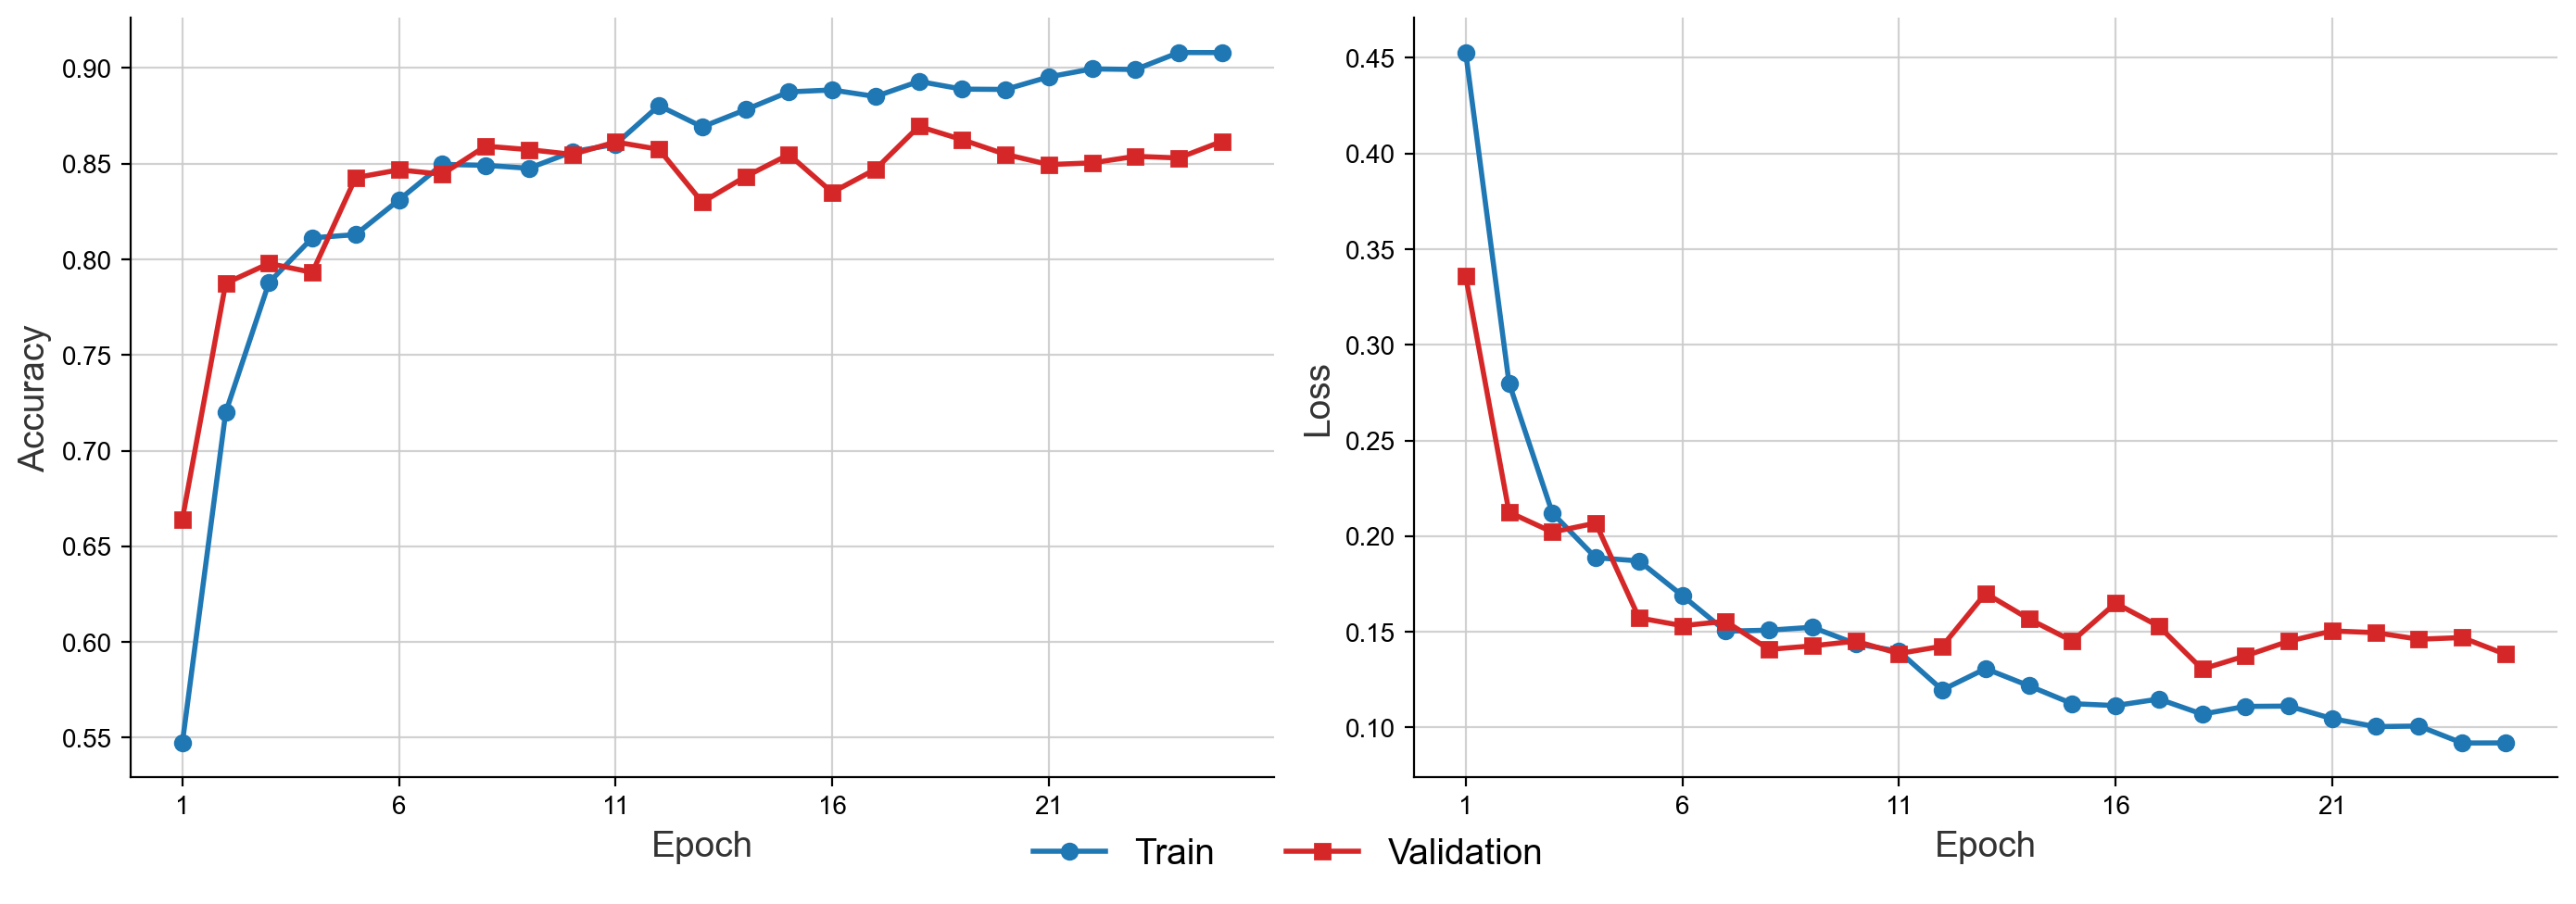

In [ ]:
# To create combined training plots
import matplotlib.pyplot as plt
import matplotlib as mpl

# Reset to default matplotlib style first to remove seaborn influence
plt.style.use('default')

# Create a clean figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=200)

# Common styling parameters
epochs = range(1, len(train_losses)+1)
line_width = 2
marker_size = 6
text_color = '#333333'
grid_color = '#CCCCCC'
accent_blue = '#1f77b4'  # Professional blue
accent_red = '#d62728'   # Professional red

# Set general figure aesthetics
fig.patch.set_facecolor('white')  # White figure background
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'axes.edgecolor': text_color,
    'axes.labelcolor': text_color,
    'xtick.color': text_color,
    'ytick.color': text_color
})

# Accuracy Plot (Left subplot)
ax1.plot(epochs, [1-loss for loss in train_losses], '-', 
        color=accent_blue, label='Train', linewidth=line_width, 
        marker='o', markersize=marker_size)
ax1.plot(epochs, [1-loss for loss in val_losses], '-', 
        color=accent_red, label='Validation', linewidth=line_width, 
        marker='s', markersize=marker_size)
# ax1.set_title('Accuracy Progress', fontsize=16, pad=10, color=text_color)
ax1.set_xlabel('Epoch', fontsize=14, color=text_color)
ax1.set_ylabel('Accuracy', fontsize=14, color=text_color)
ax1.grid(True, linestyle='-', alpha=0.9, color=grid_color)
ax1.set_facecolor('white')  # White axes background
ax1.spines['top'].set_visible(False)  # Remove top border
ax1.spines['right'].set_visible(False)  # Remove right border
ax1.set_xticks(epochs[::5])

# Loss Plot (Right subplot)
ax2.plot(epochs, train_losses, '-', 
        color=accent_blue, label='Train', linewidth=line_width, 
        marker='o', markersize=marker_size)
ax2.plot(epochs, val_losses, '-', 
        color=accent_red, label='Validation', linewidth=line_width, 
        marker='s', markersize=marker_size)
# ax2.set_title('Loss Progress', fontsize=16, pad=10, color=text_color)
ax2.set_xlabel('Epoch', fontsize=14, color=text_color)
ax2.set_ylabel('Loss', fontsize=14, color=text_color)
ax2.grid(True, linestyle='-', alpha=0.9, color=grid_color)
ax2.set_facecolor('white')  # White axes background
ax2.spines['top'].set_visible(False)  # Remove top border
ax2.spines['right'].set_visible(False)  # Remove right border
ax2.set_xticks(epochs[::5])

# Create a single legend for the entire figure
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.12),
          frameon=False, ncol=2, fontsize=14)

# Adjust layout and save
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for the legend at the bottom
plt.savefig('training_progress.png', dpi=300, bbox_inches='tight')
plt.savefig('training_progress.pdf', bbox_inches='tight')
plt.show()

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

def compute_metrics(model, loader, attack_strength=None):
    all_labels = []
    all_preds = []
    all_probs = []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            if attack_strength is not None:
                inputs = quantum_pgd_attack(model, inputs, labels, eps=attack_strength)
            
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy()[:, 1])  # Probability of positive class
    
    metrics = {
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'roc_auc': roc_auc_score(all_labels, all_probs)
    }
    return metrics


In [23]:
# Prepare data for plotting
metrics = ['precision', 'recall', 'f1', 'roc_auc']
scenarios = list(results.keys())
values = {metric: [results[scenario][metric] for scenario in scenarios] 
          for metric in metrics}

# Create radar chart for comprehensive comparison
def create_radar_chart(metrics, values, scenarios):
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True), dpi=120)
    
    # Draw one axis per metric
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([m.upper() for m in metrics])
    
    # Draw ylabels
    ax.set_rlabel_position(30)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=10)
    plt.ylim(0, 1)
    
    # Plot each scenario
    colors = plt.cm.viridis(np.linspace(0, 1, len(scenarios)))
    for idx, scenario in enumerate(scenarios):
        data = values[scenario] + values[scenario][:1]
        ax.plot(angles, data, color=colors[idx], linewidth=2, 
                linestyle='--' if idx>0 else '-', 
                marker='o' if idx>0 else 's',
                label=scenario)
    
    plt.title('Model Metrics Under Varying Attack Strengths', pad=30)
    plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('metrics_radar_chart.png', dpi=300, bbox_inches='tight')
    plt.savefig('metrics_radar_chart.pdf', bbox_inches='tight')
    plt.close()

create_radar_chart(metrics, {k: [v[m] for m in metrics] for k, v in results.items()}, scenarios)


# QC-PGD--->precision, recall, F1, and ROC-AUC scores--under varying attack strengths

In [26]:
def quantum_pgd_attack(model, inputs, labels, eps=0.03, alpha=0.01, iters=10):
    """
    Modify PGD attack with proper gradient handling
    """
    model.eval()  # Important: Set to eval mode but enable gradients
    
    # Create adversarial pattern
    adv_inputs = inputs.clone().detach().requires_grad_(True).to(device)
    original_inputs = inputs.clone().detach().to(device)
    labels = labels.to(device)
    
    for _ in range(iters):
        # Forward pass
        outputs = model(adv_inputs)
        loss = criterion(outputs, labels)
        
        # Zero existing gradients
        if adv_inputs.grad is not None:
            adv_inputs.grad.data.zero_()
        
        # Calculate gradients
        loss.backward()
        
        with torch.no_grad():
            # Apply perturbation
            perturbation = alpha * adv_inputs.grad.sign()
            adv_inputs += perturbation
            
            # Project back to epsilon ball
            adv_inputs = torch.max(torch.min(adv_inputs, 
                                          original_inputs + eps), 
                                original_inputs - eps)
            adv_inputs = torch.clamp(adv_inputs, 0, 1)  # For image data
            
        # Re-enable gradient tracking
        adv_inputs = adv_inputs.detach().requires_grad_(True)
    
    return adv_inputs.detach()


In [27]:
def compute_metrics(model, loader, attack_strength=None):
    all_labels = []
    all_preds = []
    all_probs = []
    
    model.eval()
    with torch.set_grad_enabled(attack_strength is not None):  # Enable grad only for attacks
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            if attack_strength is not None:
                # Generate adversarial examples
                adv_inputs = quantum_pgd_attack(model, inputs, labels, eps=attack_strength)
                inputs = adv_inputs
            
            # Disable grad for final prediction
            with torch.no_grad():
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)
                
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy()[:, 1])
    
    # Handle case where all predictions are one class
    if len(np.unique(all_labels)) == 1:
        roc_auc = float('nan')
    else:
        roc_auc = roc_auc_score(all_labels, all_probs)
    
    return {
        'precision': precision_score(all_labels, all_preds, zero_division=0),
        'recall': recall_score(all_labels, all_preds, zero_division=0),
        'f1': f1_score(all_labels, all_preds, zero_division=0),
        'roc_auc': roc_auc
    }


In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)  # Move the model to the correct device

attack_strengths = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]
results = {}

for eps in attack_strengths:
    key = 'Clean' if eps == 0.0 else f'ε={eps:.2f}'
    print(f"Processing {key} scenario...")

    # Compute metrics (returns both accuracy and loss)
    accuracy, loss = evaluate_robustness(model, test_loader, epsilon=eps, device=device)
    results[key] = {'accuracy': accuracy, 'loss': loss}
    
    # Print intermediate results
    print(f"{key} Results:")
    print(f"{'Accuracy':>10}: {results[key]['accuracy']:.4f}")
    print(f"{'Loss':>10}: {results[key]['loss']:.4f}")
    print()

Processing Clean scenario...
Clean Results:
  Accuracy: 0.9553
      Loss: 0.1383

Processing ε=0.01 scenario...
ε=0.01 Results:
  Accuracy: 0.2785
      Loss: 2.4905

Processing ε=0.02 scenario...
ε=0.02 Results:
  Accuracy: 0.2797
      Loss: 2.5926

Processing ε=0.03 scenario...
ε=0.03 Results:
  Accuracy: 0.2191
      Loss: 2.7097

Processing ε=0.04 scenario...
ε=0.04 Results:
  Accuracy: 0.2393
      Loss: 2.5776

Processing ε=0.05 scenario...
ε=0.05 Results:
  Accuracy: 0.2362
      Loss: 2.6766

Processing ε=0.10 scenario...
ε=0.10 Results:
  Accuracy: 0.1603
      Loss: 2.4370



In [ ]:
attack_strengths = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]
results = {}

for eps in attack_strengths:
    key = 'Clean' if eps == 0.0 else f'ε={eps:.2f}'
    print(f"Processing {key} scenario...")
    results[key] = compute_metrics(model, test_loader, attack_strength=None if eps == 0.0 else eps)
    
    # Print intermediate results
    print(f"{key} Results:")
    for metric, value in results[key].items():
        print(f"{metric:>10}: {value:.4f}")
    print()


Processing Clean scenario...
Clean Results:
 precision: 0.9625
    recall: 0.8691
        f1: 0.9134
   roc_auc: 0.9805

Processing ε=0.01 scenario...
ε=0.01 Results:
 precision: 0.1079
    recall: 0.2032
        f1: 0.1410
   roc_auc: 0.2100

Processing ε=0.02 scenario...
ε=0.02 Results:
 precision: 0.0616
    recall: 0.1129
        f1: 0.0797
   roc_auc: 0.1943

Processing ε=0.03 scenario...
ε=0.03 Results:
 precision: 0.0529
    recall: 0.1016
        f1: 0.0696
   roc_auc: 0.1467

Processing ε=0.04 scenario...
ε=0.04 Results:
 precision: 0.0484
    recall: 0.0880
        f1: 0.0625
   roc_auc: 0.1424

Processing ε=0.05 scenario...
ε=0.05 Results:
 precision: 0.0331
    recall: 0.0609
        f1: 0.0429
   roc_auc: 0.1227

Processing ε=0.10 scenario...
ε=0.10 Results:
 precision: 0.0491
    recall: 0.0903
        f1: 0.0636
   roc_auc: 0.1337



In [45]:
def compute_metrics(model, loader, attack_strength=None):
    all_labels = []
    all_preds = []
    all_probs = []
    correct = 0
    total = 0
    
    model.eval()
    with torch.set_grad_enabled(attack_strength is not None):  # Enable grad only for attacks
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            if attack_strength is not None:
                # Generate adversarial examples
                adv_inputs = quantum_pgd_attack(model, inputs, labels, eps=attack_strength)
                inputs = adv_inputs
                
            # Disable grad for final prediction
            with torch.no_grad():
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)
                
                # Calculate accuracy statistics
                total += labels.size(0)
                correct += (preds == labels).sum().item()
                
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy()[:, 1])
    
    # Calculate accuracy
    accuracy = correct / total if total > 0 else 0.0
    
    # Handle case where all predictions are one class
    if len(np.unique(all_labels)) == 1:
        roc_auc = float('nan')
    else:
        roc_auc = roc_auc_score(all_labels, all_probs)
        
    return {
        'accuracy': accuracy,
        'precision': precision_score(all_labels, all_preds, zero_division=0),
        'recall': recall_score(all_labels, all_preds, zero_division=0),
        'f1': f1_score(all_labels, all_preds, zero_division=0),
        'roc_auc': roc_auc
    }

# Define attack strengths to test
attack_strengths = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]
results = {}

for eps in attack_strengths:
    key = 'Clean' if eps == 0.0 else f'ε={eps:.2f}'
    print(f"Processing {key} scenario...")
    
    # Important fix: use the actual eps value for attack_strength
    results[key] = compute_metrics(model, test_loader, attack_strength=None if eps == 0.0 else eps)
    
    # Print intermediate results
    print(f"{key} Results:")
    for metric, value in results[key].items():
        print(f"{metric:>10}: {value:.4f}")
    print()

# Optional: Create a summary table of results
print("Summary of Results:")
metrics = list(results["Clean"].keys())
headers = ["Attack"] + metrics

# Print header
print(f"{headers[0]:>10}", end="")
for m in metrics:
    print(f"{m:>12}", end="")
print()

# Print values for each attack strength
for key in results:
    print(f"{key:>10}", end="")
    for m in metrics:
        print(f"{results[key][m]:>12.4f}", end="")
    print()

Processing Clean scenario...
Clean Results:
  accuracy: 0.9553
 precision: 0.9625
    recall: 0.8691
        f1: 0.9134
   roc_auc: 0.9805

Processing ε=0.01 scenario...
ε=0.01 Results:
  accuracy: 0.3286
 precision: 0.1070
    recall: 0.2009
        f1: 0.1396
   roc_auc: 0.2105

Processing ε=0.02 scenario...
ε=0.02 Results:
  accuracy: 0.2956
 precision: 0.0619
    recall: 0.1129
        f1: 0.0799
   roc_auc: 0.1952

Processing ε=0.03 scenario...
ε=0.03 Results:
  accuracy: 0.2632
 precision: 0.0529
    recall: 0.1016
        f1: 0.0696
   roc_auc: 0.1479

Processing ε=0.04 scenario...
ε=0.04 Results:
  accuracy: 0.2846
 precision: 0.0485
    recall: 0.0880
        f1: 0.0626
   roc_auc: 0.1412

Processing ε=0.05 scenario...
ε=0.05 Results:
  accuracy: 0.2632
 precision: 0.0331
    recall: 0.0609
        f1: 0.0429
   roc_auc: 0.1223

Processing ε=0.10 scenario...
ε=0.10 Results:
  accuracy: 0.2791
 precision: 0.0491
    recall: 0.0903
        f1: 0.0636
   roc_auc: 0.1340

Summary 

# 3D visualization--histogram for our (three) attacks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Configure Times New Roman font globally
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

# Nature Materials color palette (perceptually uniform)
colors = ['#EE7733', '#0077BB', '#33BBEE']  # Orange, Blue, Cyan
edge_colors = ['white', 'white', 'white']  # Complementary edges

# Create figure
fig = plt.figure(figsize=(12, 8), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Bar dimensions
bar_width = 0.30
bar_depth = 0.30

for i, eps in enumerate(attack_strengths):
    for j, tech in enumerate(techniques):
        acc = accuracy_data[tech][i]
        
        # Plot 3D bars with depth
        bar = ax.bar3d(
            i, j, 0,
            bar_width, bar_depth, acc,
            color=colors[j],
            edgecolor=edge_colors[j],
            linewidth=1.5,
            alpha=0.95,
            shade=True
        )
        
        # # Front-facing label placement
        # label_x = i + bar_width/2
        # label_y = j + bar_depth
        # label_z = acc + 0.1  # Slight vertical offset
        
        # ax.text(
        #     label_x, label_y, label_z,
        #     f'{acc:.2f}',
        #     color='red',
        #     fontsize=12,
        #     fontweight='bold',
        #     ha='center',
        #     va='bottom',
        #     bbox=dict(
        #         boxstyle="round,pad=0.3",
        #         facecolor=edge_colors[j],
        #         edgecolor='none',
        #         alpha=0.7
        #     )
        # )

# Axis labels with Times New Roman
ax.set_xticks(np.arange(len(attack_strengths)))
ax.set_xticklabels([f'ε={eps:.2f}' for eps in attack_strengths])
ax.set_yticks(np.arange(len(techniques)))
ax.set_yticklabels(techniques)
ax.set_zlabel('Accuracy', labelpad=14)

# Optimized viewing angle
ax.view_init(elev=28, azim=45)

# Professional legend
legend_patches = [plt.Rectangle((0,0),1,1, fc=colors[i], ec=edge_colors[i], linewidth=1) 
                 for i in range(3)]
legend = ax.legend(legend_patches, techniques,
                  loc='upper right',
                  bbox_to_anchor=(0.9, 0.8),
                  frameon=True,
                  framealpha=0.75,
                  edgecolor='k')
legend.get_title().set_fontname('Times New Roman')

# Clean background
for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis.pane.set_facecolor('white')
    axis.pane.set_edgecolor('gray')
ax.grid(True, linestyle=':', alpha=0.4)

plt.tight_layout()
plt.savefig('Adversarial_Robustness_3D.pdf', bbox_inches='tight', dpi=300)
plt.savefig('Adversarial_Robustness_3D.png', transparent=True, dpi=300)
plt.show()


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# IEEE compliant styling
plt.style.use('seaborn-paper')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.dpi': 600,
    'savefig.dpi': 600
})

# Data from your table
attack_strengths = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.10])
techniques = ['QC-FGSM', 'QC-Poison', 'QC-PGD']

# Contrast-enhanced color palette
colors = ['#E64B35', '#4DBBD5', '#00A087']  # Red, Blue, Green

# Accuracy data
accuracy_data = {
    'QC-FGSM': np.array([0.766, 0.739, 0.706, 0.680, 0.650, 0.558]),
    'QC-Poison': np.array([0.533, 0.536, 0.537, 0.539, 0.541, 0.545]),
    'QC-PGD': np.array([0.297, 0.269, 0.265, 0.250, 0.255, 0.263])
}

# Create figure
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot bars with improved visibility
for i, eps in enumerate(attack_strengths):
    for j, tech in enumerate(techniques):
        acc = accuracy_data[tech][i]
        
        # Plot bars with better edge contrast
        bar = ax.bar3d(
            x=i, y=j, z=0,
            dx=0.35, dy=0.35, dz=acc,
            color=colors[j], alpha=0.9,
            edgecolor='black', linewidth=0.5
        )
        
        # Label positioning based on height
        va = 'bottom' if acc > 0.3 else 'top'
        z_pos = acc + 0.03 if acc > 0.3 else acc - 0.03
        color = 'black' if acc > 0.3 else 'white'
        
        ax.text(
            x=i, y=j, z=z_pos,
            s=f'{acc:.3f}',
            ha='center', va=va,
            color=color, fontsize=12,
            bbox=dict(facecolor='white', alpha=0.7, pad=0, edgecolor='none') if acc <= 0.3 else None
        )

# Optimized view angles
ax.view_init(elev=28, azim=45)

# Axis labels
ax.set_xticks(np.arange(len(attack_strengths)))
ax.set_xticklabels([f'ε={eps:.2f}' for eps in attack_strengths], fontweight='bold')
ax.set_yticks(np.arange(len(techniques)))
ax.set_yticklabels(techniques, fontweight='bold')
ax.set_zlabel('Accuracy', fontweight='bold', labelpad=15)
ax.set_xlabel('Attack Strength', fontweight='bold', labelpad=15)

# Improved grid and background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(True, linestyle=':', alpha=0.8)

# Enhanced legend placement and styling
legend_elements = [
    plt.Rectangle((0,0), 1, 1, fc=colors[0], ec='black'),
    plt.Rectangle((0,0), 1, 1, fc=colors[1], ec='black'),
    plt.Rectangle((0,0), 1, 1, fc=colors[2], ec='black')
]

legend = ax.legend(legend_elements, techniques, 
                  loc='upper left', 
                  bbox_to_anchor=(0.7, 0.7),
                  frameon=True,
                  title='Attack Techniques',
                  title_fontsize=14)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)

# Adjust layout
plt.tight_layout()

# Save output
plt.savefig('3d_attack_comparison_optimized11.pdf', bbox_inches='tight')
plt.savefig('3d_attack_comparison_optimized11.png', dpi=600)
plt.close()


/tmp/ipykernel_1309262/3576927779.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')
/tmp/ipykernel_1309262/3576927779.py:96: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Configure Times New Roman font globally
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 13,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 12
})

# Nature Materials color palette (perceptually uniform)
colors = ['#EE7733', '#0077BB', '#33BBEE']  # Orange, Blue, Cyan
edge_colors = ['#CC3311', '#005599', '#0099BB']  # Complementary edges

# Create figure
fig = plt.figure(figsize=(12, 8), dpi=600)
ax = fig.add_subplot(111, projection='3d')

# Bar dimensions
bar_width = 0.35
bar_depth = 0.35

for i, eps in enumerate(attack_strengths):
    for j, tech in enumerate(techniques):
        acc = accuracy_data[tech][i]
        
        # Plot 3D bars with depth
        bar = ax.bar3d(
            i, j, 0,
            bar_width, bar_depth, acc,
            color=colors[j],
            edgecolor=edge_colors[j],
            linewidth=1.2,
            alpha=0.95,
            shade=True
        )
        
        # Front-facing label placement
        label_x = i + bar_width/2
        label_y = j + bar_depth
        label_z = acc + 0.02  # Slight vertical offset
        
        ax.text(
            label_x, label_y, label_z,
            f'{acc:.2f}',
            color='white',
            fontsize=12,
            fontweight='bold',
            ha='center',
            va='bottom',
            bbox=dict(
                boxstyle="round,pad=0.2",
                facecolor=edge_colors[j],
                edgecolor='none',
                alpha=0.9
            )
        )

# Axis labels with Times New Roman
ax.set_xticks(np.arange(len(attack_strengths)))
ax.set_xticklabels([f'ε={eps:.2f}' for eps in attack_strengths], fontweight='bold')
ax.set_yticks(np.arange(len(techniques)))
ax.set_yticklabels(techniques, fontweight='bold')
ax.set_zlabel('Accuracy', fontweight='bold', labelpad=12)

# Optimized viewing angle
ax.view_init(elev=28, azim=135)

# Professional legend
legend_patches = [plt.Rectangle((0,0),1,1, fc=colors[i], ec=edge_colors[i], linewidth=1.2) 
                 for i in range(3)]
legend = ax.legend(legend_patches, techniques,
                  loc='upper right',
                  bbox_to_anchor=(0.9, 0.8),
                  frameon=True,
                  framealpha=0.95,
                  edgecolor='k')
legend.get_title().set_fontname('Times New Roman')

# Clean background
for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis.pane.set_facecolor('white')
    axis.pane.set_edgecolor('gray')
ax.grid(True, linestyle=':', alpha=0.4)

plt.tight_layout()
plt.savefig('Adversarial_Robustness_3D.pdf', bbox_inches='tight', dpi=300)
plt.savefig('Adversarial_Robustness_3D.png', transparent=True, dpi=300)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter

# Data for quantum computing methods
attack_strengths = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.10])
techniques = ['QC-FGSM', 'QC-Poison', 'QC-PGD']

# Accuracy data
accuracy_data = {
    'QC-FGSM': np.array([0.766, 0.739, 0.706, 0.680, 0.650, 0.558]),
    'QC-Poison': np.array([0.533, 0.536, 0.537, 0.539, 0.541, 0.545]),
    'QC-PGD': np.array([0.297, 0.269, 0.265, 0.250, 0.255, 0.263])
}

# IEEE Transactions on Communications specifications
# Single column: 3.5 inches (88.9 mm)
# Double column: 7.16 inches (181.9 mm)
column_width_inches = 7.16  # Using double column width
golden_ratio = 0.618  # Aesthetically pleasing height-to-width ratio

# Set up IEEE style
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'mathtext.fontset': 'stix',
    'font.size': 8,  # IEEE typically uses 8pt font
    'axes.labelsize': 9,
    'axes.titlesize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'axes.linewidth': 0.5
})

# Create figure with IEEE dimensions
fig = plt.figure(figsize=(column_width_inches, column_width_inches * golden_ratio), dpi=600)

# Create a grid of subplots (3D bar chart and line plot)
gs = fig.add_gridspec(2, 1, height_ratios=[1.8, 1])

# Main 3D visualization
ax1 = fig.add_subplot(gs[0, 0], projection='3d')

# Create custom colormaps for each technique
colors = {
    'QC-FGSM': plt.cm.Reds,
    'QC-Poison': plt.cm.Blues,
    'QC-PGD': plt.cm.Greens
}

# Plotting parameters
min_alpha = 0.7
max_alpha = 1.0
width = depth = 0.7
spacing = 1.0

# Plot the data as vertical cylinders with gradient coloring
for i, technique in enumerate(techniques):
    # Get colormap for this technique
    cmap = colors[technique]
    
    for j, eps in enumerate(attack_strengths):
        # Get accuracy value
        height = accuracy_data[technique][j]
        
        # Calculate position
        x = j * spacing
        y = i * spacing
        
        # Color intensity based on attack strength
        color_intensity = j / (len(attack_strengths) - 1)
        color = cmap(0.3 + 0.7 * color_intensity)
        
        # Create cylinder
        ax1.bar3d(
            x, y, 0,
            width, depth, height,
            color=color,
            edgecolor='black',
            linewidth=0.5,
            shade=True,
            alpha=min_alpha + (max_alpha - min_alpha) * color_intensity
        )
        
        # Add text label on top of each bar
        ax1.text(
            x + width/2,
            y + depth/2,
            height + 0.02,
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=7,
            fontweight='bold',
            color='black',
            zorder=100
        )

# Set labels and title
ax1.set_xlabel('Attack Strength (ε)', fontweight='bold', labelpad=8)
ax1.set_ylabel('Defense Method', fontweight='bold', labelpad=8)
ax1.set_zlabel('Accuracy', fontweight='bold', labelpad=8)

# Set custom tick labels
x_positions = np.arange(0, len(attack_strengths) * spacing, spacing)
y_positions = np.arange(0, len(techniques) * spacing, spacing)
ax1.set_xticks(x_positions + width/2)
ax1.set_yticks(y_positions + depth/2)
ax1.set_xticklabels([f'ε={eps:.2f}' for eps in attack_strengths])
ax1.set_yticklabels(techniques)
ax1.set_zlim(0, 1.0)
ax1.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# Set optimal viewing angle
ax1.view_init(elev=35, azim=225)

# Add a line plot showing trends across attack strengths
ax2 = fig.add_subplot(gs[1, 0])
for i, technique in enumerate(techniques):
    line_color = colors[technique](0.7)
    marker_styles = ['o', 's', '^']  # Different marker for each technique
    ax2.plot(
        attack_strengths,
        accuracy_data[technique],
        marker=marker_styles[i],
        markersize=5,
        linewidth=1.5,
        label=technique,
        color=line_color
    )
    
    # Add value labels at each point
    for j, (eps, acc) in enumerate(zip(attack_strengths, accuracy_data[technique])):
        # Only label selected points to avoid overcrowding
        if j % 2 == 0 or j == len(attack_strengths) - 1:
            ax2.text(
                eps, 
                acc + 0.02,
                f'{acc:.2f}',
                ha='center',
                va='bottom',
                fontsize=6,
                color=line_color
            )

ax2.set_xlabel('Attack Strength (ε)', fontweight='bold')
ax2.set_ylabel('Accuracy', fontweight='bold')
ax2.set_title('Trend Analysis Across Attack Strengths', fontsize=9, fontweight='bold')
ax2.grid(True, linestyle='-', alpha=0.3, linewidth=0.2)
ax2.set_ylim(0, 1.0)

# Add legend with enhanced styling
legend = ax2.legend(loc='upper right', frameon=True, framealpha=0.9, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.2)

# # Add figure numbers and labels as per IEEE style
# ax1.set_title('(a) 3D Visualization of Defense Method Performance', fontsize=9, fontweight='bold')
# ax2.set_title('(b) Accuracy Trends Across Attack Strengths', fontsize=9, fontweight='bold')

# Tight layout for IEEE specifications
plt.tight_layout()

# Save the 3D bar chart separately
plt.savefig('QC_3D_Visualization_IEEE.pdf', format='pdf', bbox_inches='tight', dpi=600)
plt.savefig('QC_3D_Visualization_IEEE.eps', format='eps', bbox_inches='tight', dpi=600)
plt.savefig('QC_3D_Visualization_IEEE.png', format='png', bbox_inches='tight', dpi=600)

# Now create and save just the 3D visualization separately
fig_3d = plt.figure(figsize=(column_width_inches*0.6, column_width_inches*0.6), dpi=600)
ax_3d = fig_3d.add_subplot(111, projection='3d')

# Repeat the 3D plotting code for the separate figure
for i, technique in enumerate(techniques):
    cmap = colors[technique]
    for j, eps in enumerate(attack_strengths):
        height = accuracy_data[technique][j]
        x = j * spacing
        y = i * spacing
        color_intensity = j / (len(attack_strengths) - 1)
        color = cmap(0.3 + 0.7 * color_intensity)
        
        ax_3d.bar3d(
            x, y, 0,
            width, depth, height,
            color=color,
            edgecolor='black',
            linewidth=0.5,
            shade=True,
            alpha=min_alpha + (max_alpha - min_alpha) * color_intensity
        )
        
        ax_3d.text(
            x + width/2,
            y + depth/2,
            height + 0.02,
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=7,
            fontweight='bold',
            color='black',
            zorder=100
        )

# Set labels and formatting for separate 3D figure
ax_3d.set_xlabel('Attack Strength (ε)', fontweight='bold', labelpad=8)
ax_3d.set_ylabel('Attack Method', fontweight='bold', labelpad=8)
ax_3d.set_zlabel('Accuracy', fontweight='bold', labelpad=8)
ax_3d.set_xticks(x_positions + width/2)
ax_3d.set_yticks(y_positions + depth/2)
ax_3d.set_xticklabels([f'ε={eps:.2f}' for eps in attack_strengths])
ax_3d.set_yticklabels(techniques)
ax_3d.set_zlim(0, 1.0)
ax_3d.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax_3d.view_init(elev=35, azim=225)
# ax_3d.set_title('3D Visualization of QC Defense Methods', fontsize=9, fontweight='bold')

plt.tight_layout()

# Save the standalone 3D figure
plt.savefig('QC_3D_Bars_Only_IEEE.pdf', format='pdf', bbox_inches='tight', dpi=600)
plt.savefig('QC_3D_Bars_Only_IEEE.eps', format='eps', bbox_inches='tight', dpi=600)
plt.savefig('QC_3D_Bars_Only_IEEE.png', format='png', bbox_inches='tight', dpi=600)

# Create and save just the trend line plot separately
fig_trend = plt.figure(figsize=(column_width_inches*0.6, column_width_inches*0.4), dpi=600)
ax_trend = fig_trend.add_subplot(111)

# Repeat the trend line plotting code for the separate figure
for i, technique in enumerate(techniques):
    line_color = colors[technique](0.7)
    marker_styles = ['o', 's', '^']
    ax_trend.plot(
        attack_strengths,
        accuracy_data[technique],
        marker=marker_styles[i],
        markersize=5,
        linewidth=1.5,
        label=technique,
        color=line_color
    )
    
    for j, (eps, acc) in enumerate(zip(attack_strengths, accuracy_data[technique])):
        if j % 2 == 0 or j == len(attack_strengths) - 1:
            ax_trend.text(
                eps, 
                acc + 0.02,
                f'{acc:.2f}',
                ha='center',
                va='bottom',
                fontsize=6,
                color=line_color
            )

# Set labels and formatting for separate trend figure
ax_trend.set_xlabel('Attack Strength (ε)')
ax_trend.set_ylabel('Accuracy')
ax_trend.set_title('Accuracy dropping trends', fontsize=16, )
ax_trend.grid(True, linestyle='-', alpha=0.9, linewidth=0.2)
ax_trend.set_ylim(0, 1.0)

legend = ax_trend.legend(loc='upper right', frameon=True, framealpha=0.9, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.2)

plt.tight_layout()

# Save the standalone trend figure
plt.savefig('QC_Trend_Lines_Only_IEEE.pdf', format='pdf', bbox_inches='tight', dpi=600)
plt.savefig('QC_Trend_Lines_Only_IEEE.eps', format='eps', bbox_inches='tight', dpi=600)
plt.savefig('QC_Trend_Lines_Only_IEEE.png', format='png', bbox_inches='tight', dpi=600)

plt.show()

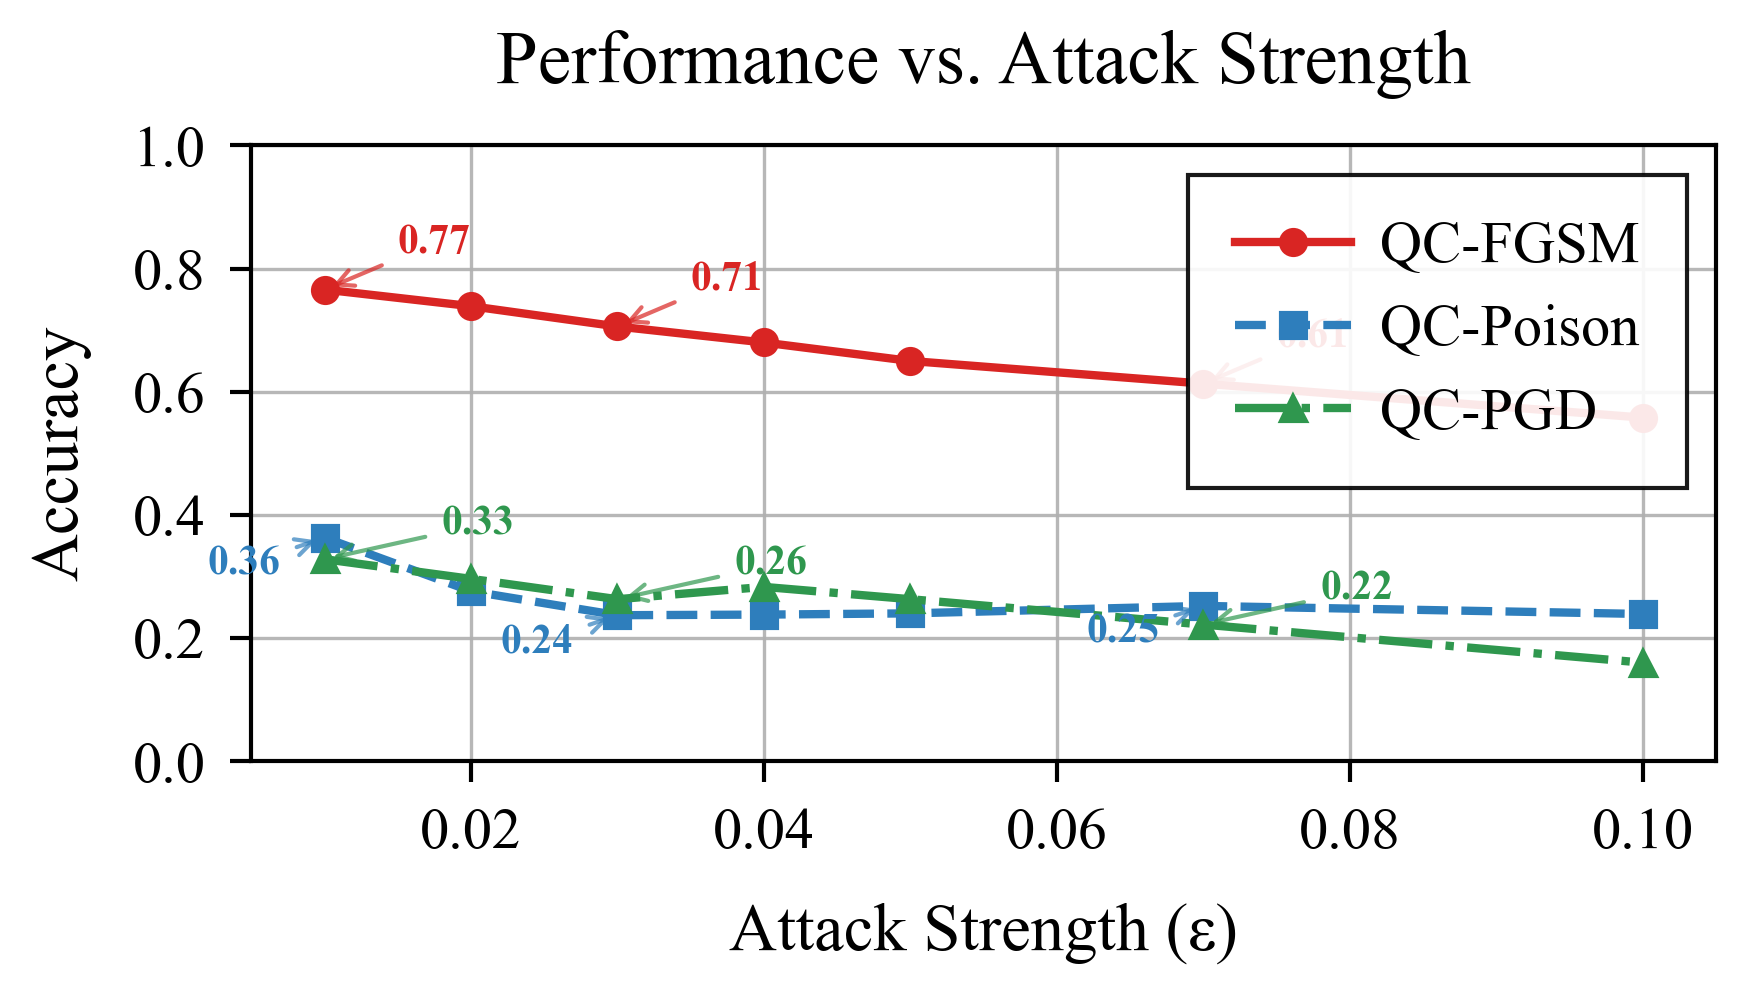

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Data for quantum computing methods
attack_strengths = np.array([0.01, 0.02, 0.03, 0.04, 0.05,0.07, 0.10])
techniques = ['QC-FGSM', 'QC-Poison', 'QC-PGD']

# Updated accuracy data
accuracy_data = {
    'QC-FGSM': np.array([0.766, 0.739, 0.706, 0.680, 0.650,0.6132,0.558]),
    'QC-Poison': np.array([0.363, 0.276, 0.237, 0.238, 0.240, 0.2521, 0.239]),
    'QC-PGD': np.array([0.328, 0.296, 0.263, 0.283, 0.263, 0.2218, 0.160])
}

# IEEE Transactions on Communications specifications - double column
column_width_inches = 7.16  # Double column width in inches

# Set up IEEE style with LARGER fonts for better readability
plt.rcParams.update({
    'font.family': 'serif',
    # 'font.serif': ['Calibri'],
    'mathtext.fontset': 'stix',
    'font.size': 14,            # Increased from 8
    'axes.labelsize': 16,       # Increased from 9
    'axes.titlesize': 18,       # Increased from 10
    'xtick.labelsize': 14,      # Increased from 8
    'ytick.labelsize': 14,      # Increased from 8
    'legend.fontsize': 14,      # Increased from 8
    'axes.linewidth': 1.0       # Increased from 0.5
})

# Create figure specifically sized for the trend plot
fig_trend = plt.figure(figsize=(column_width_inches*0.85, column_width_inches*0.5), dpi=300)
ax_trend = fig_trend.add_subplot(111)  # Fixed the variable name from fig to fig_trend

# Create custom colormaps for each technique
colors = {
    'QC-FGSM': plt.cm.Reds,
    'QC-Poison': plt.cm.Blues,
    'QC-PGD': plt.cm.Greens
}

# Different marker styles and line styles for better distinction
marker_styles = ['o', 's', '^']  # Circle, Square, Triangle
line_styles = ['-', '--', '-.']  # Solid, Dashed, Dash-dot

# Plot trend lines with enhanced visibility
for i, technique in enumerate(techniques):
    line_color = colors[technique](0.7)
    ax_trend.plot(
        attack_strengths,
        accuracy_data[technique],
        marker=marker_styles[i],
        linestyle=line_styles[i],
        markersize=6,           # Increased from 5
        linewidth=2.0,          # Increased from 1.5
        label=technique,
        color=line_color
    )
    
    # Use annotations with arrows for cleaner labeling
    for j, (eps, acc) in enumerate(zip(attack_strengths, accuracy_data[technique])):
        # Only label specific points to reduce crowding
        if j in [0, 2, 5]:  # First, middle, and last points
            # Position text away from points with different offsets for each technique
            if technique == 'QC-FGSM':
                x_offset, y_offset = 0.005, 0.06
            elif technique == 'QC-Poison':
                x_offset, y_offset = -0.008, -0.06
            else:  # QC-PGD
                x_offset, y_offset = 0.008, 0.04
                
            ax_trend.annotate(
                f'{acc:.2f}',
                xy=(eps, acc),  # Point to annotate
                xytext=(eps + x_offset, acc + y_offset),  # Text position
                arrowprops=dict(
                    arrowstyle='->', 
                    lw=1.0,
                    color=line_color,
                    alpha=0.7
                ),
                fontsize=10,
                fontweight='bold',
                color=line_color
            )

# Enhanced axis labels and title
ax_trend.set_xlabel('Attack Strength (ε)', labelpad=10)
ax_trend.set_ylabel('Accuracy', labelpad=10)
ax_trend.set_title('Performance vs. Attack Strength', fontsize=18, pad=15)

# Improved grid and axis styling
ax_trend.grid(True, linestyle='-', alpha=0.9, linewidth=0.8)
ax_trend.set_ylim(0, 1.0)
ax_trend.set_xlim(0.005, 0.105)  # Slight margin around data points

# Enhance tick marks
ax_trend.tick_params(axis='both', width=1.0, length=5, pad=6)

# Enhanced legend with better positioning
legend = ax_trend.legend(
    loc='upper right', 
    frameon=True, 
    framealpha=0.9, 
    edgecolor='black', 
    fancybox=False,
    borderpad=0.8,
    handletextpad=0.5,
    handlelength=2.0
)
legend.get_frame().set_linewidth(1.0)

# Tight layout with extra margins for better spacing
plt.tight_layout(pad=1.2)

# Save the trend figure in requested formats using the correct fig_trend variable
fig_trend.savefig('drop_trend_lines1.pdf', format='pdf', bbox_inches='tight', dpi=300)
fig_trend.savefig('drop_trend_lines1.png', format='png', bbox_inches='tight', dpi=300)

plt.show()